In [1]:
from pathlib import Path

if Path.cwd().stem == "measurement":
    %cd ../../..
    %load_ext autoreload
    %autoreload 2

/Users/visser/Dropbox/PhD/Code/pain-measurement


In [7]:
import matplotlib.pyplot as plt

In [8]:
from src.plots.plot_stimulus import plot_stimulus_with_shapes


In [35]:
import numpy as np
import scipy.signal

DEFAULTS = {
    "sample_rate": 10,
    "half_cycle_num": 10,
    "period_range": [5, 20],
    "amplitude_range": [0.3, 1.0],
    "inflection_point_range": [-0.4, 0.3],
    "shorten_expected_duration": 2,
    "major_decreasing_half_cycle_num": 3,
    "major_decreasing_half_cycle_period": 20,
    "major_decreasing_half_cycle_amplitude": 0.925,
    "major_decreasing_half_cycle_min_y_intercept": 0.9,
    "plateau_num": 2,
    "plateau_duration": 15,
    "plateau_percentile_range": [25, 50],
    "prolonged_minima_num": 1,
    "prolonged_minima_duration": 5,
    "temperature_baseline": 47,
    "temperature_range": 1.5,
}


def cosine_half_cycle(period, amplitude, y_intercept=0, t_start=0, sample_rate=10):
    frequency = 1 / period
    num_steps = int(period * sample_rate)
    t = np.linspace(0, period, num_steps)
    y = amplitude * np.cos(np.pi * frequency * t) + y_intercept - amplitude
    t += t_start
    return t, y


class StimulusGenerator:
    def __init__(self, config=None, seed=None, debug=False):
        self.config = {**DEFAULTS, **(config or {})}
        self.seed = seed if seed is not None else np.random.randint(100, 1000)
        self.rng_numpy = np.random.default_rng(self.seed)
        self.debug = debug

        for key, value in self.config.items():
            setattr(self, key, value)

        self._validate_parameters()
        self._initialize_dynamic_attributes()

        self.y = None
        self.indices = []
        self._generate_stimulus()
        self._compute_initial_indices()

        if not self.debug:
            self.add_plateaus()
            self.add_prolonged_minima()
            self.add_calibration()

    def _validate_parameters(self):
        assert (
            self.major_decreasing_half_cycle_min_y_intercept < self.amplitude_range[1]
        )
        assert self.major_decreasing_half_cycle_amplitude < self.amplitude_range[1]
        assert self.plateau_duration != self.prolonged_minima_duration

    def _initialize_dynamic_attributes(self):
        self.desired_length_random_half_cycles = (
            self._get_desired_length_random_half_cycles()
        )
        self.desired_length_major_decreasing_half_cycles = (
            self._get_desired_length_major_decreasing_half_cycles()
        )
        self.desired_length = self._get_desired_length()
        self.major_decreasing_half_cycle_idx = (
            self._get_major_decreasing_half_cycle_idx()
        )
        self.major_decreasing_half_cycle_idx_for_insert = (
            self._get_major_decreasing_half_cycle_idx_for_insert()
        )
        self.periods = self._get_periods()
        self.amplitudes = self._get_amplitudes()

    def _get_desired_length_random_half_cycles(self):
        length = (
            (self.period_range[0] + self.period_range[1])
            / 2
            * (self.half_cycle_num - self.major_decreasing_half_cycle_num)
            * self.sample_rate
        ) - (self.shorten_expected_duration * self.sample_rate)
        return int(length - (length % self.sample_rate))

    def _get_desired_length_major_decreasing_half_cycles(self):
        return int(
            self.major_decreasing_half_cycle_period
            * self.major_decreasing_half_cycle_num
            * self.sample_rate
        )

    def _get_desired_length(self):
        length = (
            self.desired_length_random_half_cycles
            + self.desired_length_major_decreasing_half_cycles
        )
        return int(length - (length % self.sample_rate))

    def _get_major_decreasing_half_cycle_idx(self):
        return np.sort(
            self.rng_numpy.choice(
                range(1, self.half_cycle_num, 2),
                self.major_decreasing_half_cycle_num,
                replace=False,
            )
        )

    def _get_major_decreasing_half_cycle_idx_for_insert(self):
        return [i - idx for idx, i in enumerate(self.major_decreasing_half_cycle_idx)]

    def _get_periods(self):
        while True:
            periods = self.rng_numpy.integers(
                self.period_range[0],
                self.period_range[1],
                self.half_cycle_num - self.major_decreasing_half_cycle_num,
                endpoint=True,
            )
            if (
                np.sum(periods) * self.sample_rate
                == self.desired_length_random_half_cycles
            ):
                break
        return np.insert(
            periods,
            self.major_decreasing_half_cycle_idx_for_insert,
            self.major_decreasing_half_cycle_period,
        )

    def _get_amplitudes(self) -> np.ndarray:
        """
        Get amplitudes for the half cycles (iteratively).

        Note that this code it less readable than the vectorized _get_periods,
        but for the dependent nature of the amplitudes on the y_intercepts,
        looping is much more efficient and much faster than vectorized
        brute force operations.
        If one intercept is invalid we do not need to recompute the entire array,
        just the current value.

        Contraints:
        - The resulting function must be within -1 and 1.
        - The y_intercept of each major decrease is greater than
          major_decreasing_half_cycle_min_y_intercept.
        - The inflection point of each cosine segment is within inflection_point_range.
        """
        retry_limit_per_half_cycle = 5
        counter = 0

        while True:
            success = True
            amplitudes = []
            y_intercepts = []
            y_intercept = -1  # starting intercept

            # Iterate over the half cycles
            for i in range(self.half_cycle_num):
                retries = retry_limit_per_half_cycle
                valid_amplitude_found = False

                # Try to find a valid amplitude for the current half cycle
                while retries > 0 and not valid_amplitude_found:
                    counter += 1
                    if i in self.major_decreasing_half_cycle_idx:
                        amplitude = self.major_decreasing_half_cycle_amplitude
                    else:
                        amplitude = self.rng_numpy.uniform(
                            self.amplitude_range[0], self.amplitude_range[1]
                        )
                        if i % 2 == 0:
                            # invert amplitude for the increasing half cycles (cosine)
                            amplitude *= -1
                    next_y_intercept = y_intercept + amplitude * -2

                    if (
                        -1 <= next_y_intercept <= 1
                        and self.inflection_point_range[0]
                        <= (next_y_intercept + y_intercept) / 2
                        <= self.inflection_point_range[1]
                    ):
                        valid_amplitude_found = True
                        amplitudes.append(amplitude)
                        y_intercepts.append(y_intercept)
                        y_intercept = next_y_intercept
                    else:
                        retries -= 1

                # If no valid amplitude was found, break the loop and start over
                if not valid_amplitude_found:
                    success = False
                    break
            if not success:
                continue

            # Final check for the major decreasing half cycles
            major_decreases_high_enough = np.all(
                np.array(y_intercepts)[self.major_decreasing_half_cycle_idx]
                > self.major_decreasing_half_cycle_min_y_intercept
            )
            if major_decreases_high_enough:
                break

        if self.debug:
            print(f"Amplitudes: {counter} iterations to converge")
        return amplitudes

    def _generate_stimulus(self):
        yi = []
        t_start = 0
        y_intercept = -1
        for i in range(self.half_cycle_num):
            t, y = cosine_half_cycle(
                self.periods[i],
                self.amplitudes[i],
                y_intercept,
                t_start,
                self.sample_rate,
            )
            y_intercept = y[-1]
            t_start = t[-1]
            yi.append(y)
        self.y = np.concatenate(yi)

    def _compute_initial_indices(self):
        self.indices = []
        start = 0
        for i, period in enumerate(self.periods):
            end = start + int(period * self.sample_rate)
            self.indices.append(
                [start, end, "increasing" if self.amplitudes[i] < 0 else "decreasing"]
            )
            start = end
        self.indices = np.array(self.indices, dtype=object)

    def _update_indices(self, insert_idx, insert_length):
        mask = self.indices[:, 0].astype(int) >= insert_idx
        self.indices[mask, 0] = self.indices[mask, 0].astype(int) + insert_length
        self.indices[mask, 1] = self.indices[mask, 1].astype(int) + insert_length

        split_idx = np.searchsorted(self.indices[:, 1].astype(int), insert_idx) - 1
        original_end = int(self.indices[split_idx, 1])
        self.indices[split_idx, 1] = insert_idx

        new_interval = np.array(
            [[insert_idx, insert_idx + insert_length, "plateau"]], dtype=object
        )
        self.indices = np.insert(self.indices, split_idx + 1, new_interval, axis=0)

        if original_end > insert_idx + insert_length:
            remainder = np.array(
                [
                    [
                        insert_idx + insert_length,
                        original_end,
                        self.indices[split_idx, 2],
                    ]
                ],
                dtype=object,
            )
            self.indices = np.insert(self.indices, split_idx + 2, remainder, axis=0)

    def add_calibration(self):
        self.y *= round(self.temperature_range / 2, 2)
        self.y += self.temperature_baseline

    def add_plateaus(self):
        percentile_low = np.percentile(self.y, self.plateau_percentile_range[0])
        percentile_high = np.percentile(self.y, self.plateau_percentile_range[1])
        idx_between_values = np.where(
            (self.y > percentile_low)
            & (self.y < percentile_high)
            & (np.gradient(self.y, 1 / self.sample_rate) > 0.05)
        )[0]

        for _ in range(100):  # Limit iterations to prevent infinite loop
            idx_plateaus = self.rng_numpy.choice(
                idx_between_values, self.plateau_num, replace=False
            )
            idx_plateaus = np.sort(idx_plateaus)
            if np.all(
                np.diff(idx_plateaus) > 1.5 * self.plateau_duration * self.sample_rate
            ):
                break
        else:
            raise ValueError(
                "Unable to add the specified number of plateaus within the given wave."
            )

        for idx in idx_plateaus:
            plateau_value = self.y[idx]
            insert_length = int(self.plateau_duration * self.sample_rate)
            self.y = np.insert(self.y, idx, np.full(insert_length, plateau_value))
            self._update_indices(idx, insert_length)

    def add_prolonged_minima(self):
        minima_indices, _ = scipy.signal.find_peaks(-self.y, prominence=0.5)
        minima_values = self.y[minima_indices]
        smallest_minima_indices = np.argsort(minima_values)[: self.prolonged_minima_num]
        prolonged_minima_indices = minima_indices[smallest_minima_indices]

        for idx in prolonged_minima_indices:
            minima_value = self.y[idx]
            insert_length = int(self.prolonged_minima_duration * self.sample_rate)
            self.y = np.insert(self.y, idx, np.full(insert_length, minima_value))
            self._update_indices(idx, insert_length)

    @property
    def duration(self):
        return len(self.y) / self.sample_rate

    @property
    def t(self):
        return np.linspace(0, self.duration, len(self.y))

    @property
    def y_dot(self):
        return np.gradient(self.y, 1 / self.sample_rate)

    @property
    def labels(self):
        labels = {
            "decreasing_intervals": [],
            "major_decreasing_intervals": [],
            "increasing_intervals": [],
            "plateau_intervals": [],
            "prolonged_minima_intervals": [],
        }

        for start, end, label in self.indices:
            interval = (
                int(start * 1000 / self.sample_rate),
                int(end * 1000 / self.sample_rate),
            )
            if label == "decreasing":
                labels["decreasing_intervals"].append(interval)
                if (
                    end - start
                    >= self.major_decreasing_half_cycle_period * self.sample_rate
                ):
                    labels["major_decreasing_intervals"].append(interval)
            elif label == "increasing":
                labels["increasing_intervals"].append(interval)
            elif label == "plateau":
                if end - start == self.plateau_duration * self.sample_rate:
                    labels["plateau_intervals"].append(interval)
                elif end - start == self.prolonged_minima_duration * self.sample_rate:
                    labels["prolonged_minima_intervals"].append(interval)

        # Convert all values to integers
        for key in labels:
            labels[key] = [tuple(map(int, interval)) for interval in labels[key]]

        # Ensure all major decreasing intervals are in decreasing_intervals
        labels["decreasing_intervals"] = list(
            set(labels["decreasing_intervals"] + labels["major_decreasing_intervals"])
        )

        return labels


stimulus = StimulusGenerator(seed=396)
print(stimulus.labels)


{'decreasing_intervals': [(32000, 50000), (24300, 160000), (141000, 161000), (171000, 29300), (69000, 89000), (99000, 119000)], 'major_decreasing_intervals': [(24300, 160000), (69000, 89000), (99000, 119000), (141000, 161000)], 'increasing_intervals': [(0, 17000), (50000, 69000), (89000, 106700), (134000, 160900), (166000, 171000)], 'plateau_intervals': [(9300, 24300), (106700, 121700)], 'prolonged_minima_intervals': [(160900, 165900)]}


In [51]:
stimulus.indices
labels = np.array(sorted(stimulus.indices, key=lambda row: row[0]), dtype=object)
converted_array = np.array(
    [[int(row[0]), int(row[1]), row[2]] for row in labels], dtype=object
)
converted_array

array([[0, 170, 'increasing'],
       [93, 243, 'plateau'],
       [243, 1600, 'decreasing'],
       [320, 500, 'decreasing'],
       [500, 690, 'increasing'],
       [690, 890, 'decreasing'],
       [890, 1067, 'increasing'],
       [990, 1190, 'decreasing'],
       [1067, 1217, 'plateau'],
       [1340, 1609, 'increasing'],
       [1410, 1610, 'decreasing'],
       [1609, 1659, 'plateau'],
       [1660, 1710, 'increasing'],
       [1710, 293, 'decreasing']], dtype=object)

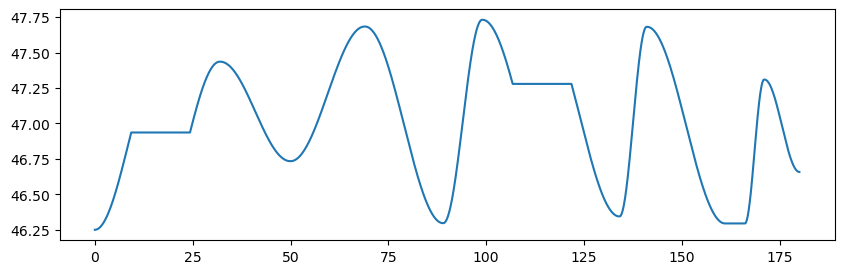

In [37]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.plot(stimulus.t, stimulus.y)


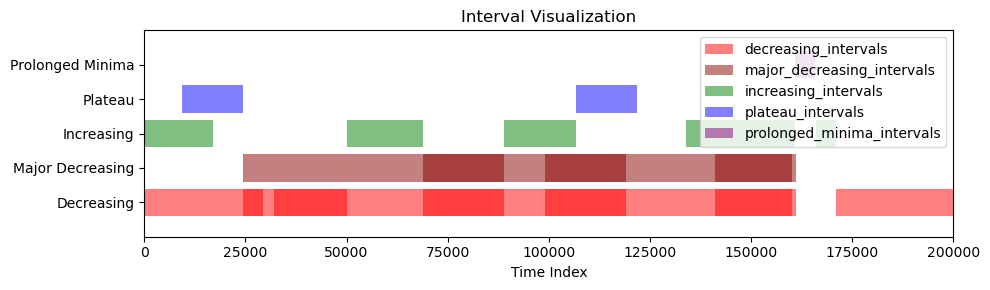

In [38]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Given data
data = {
    "decreasing_intervals": [
        (24300, 160000),
        (32000, 50000),
        (69000, 89000),
        (99000, 119000),
        (141000, 161000),
        (171000, 29300),
    ],
    "major_decreasing_intervals": [
        (24300, 160000),
        (69000, 89000),
        (99000, 119000),
        (141000, 161000),
    ],
    "increasing_intervals": [
        (0, 17000),
        (50000, 69000),
        (89000, 106700),
        (134000, 160900),
        (166000, 171000),
    ],
    "plateau_intervals": [(9300, 24300), (106700, 121700)],
    "prolonged_minima_intervals": [(160900, 165900)],
}

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 3))

# Define colors for each type of interval
colors = {
    "decreasing_intervals": "red",
    "major_decreasing_intervals": "darkred",
    "increasing_intervals": "green",
    "plateau_intervals": "blue",
    "prolonged_minima_intervals": "purple",
}

# Set the y-positions for each type of interval
y_positions = {
    "decreasing_intervals": 1,
    "major_decreasing_intervals": 2,
    "increasing_intervals": 3,
    "plateau_intervals": 4,
    "prolonged_minima_intervals": 5,
}

# Plot rectangles for each interval
for interval_type, intervals in data.items():
    for start, end in intervals:
        if start > end:  # Handle wrap-around case
            rect = patches.Rectangle(
                (start, y_positions[interval_type] - 0.4),
                200000 - start,
                0.8,
                facecolor=colors[interval_type],
                alpha=0.5,
            )
            ax.add_patch(rect)
            rect = patches.Rectangle(
                (0, y_positions[interval_type] - 0.4),
                end,
                0.8,
                facecolor=colors[interval_type],
                alpha=0.5,
            )
            ax.add_patch(rect)
        else:
            rect = patches.Rectangle(
                (start, y_positions[interval_type] - 0.4),
                end - start,
                0.8,
                facecolor=colors[interval_type],
                alpha=0.5,
            )
            ax.add_patch(rect)

# Set the limits of the plot
ax.set_xlim(0, 200000)
ax.set_ylim(0, 6)

# Set the y-axis ticks and labels
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(
    ["Decreasing", "Major Decreasing", "Increasing", "Plateau", "Prolonged Minima"]
)

# Set the title and labels
ax.set_title("Interval Visualization")
ax.set_xlabel("Time Index")

# Add a legend
legend_elements = [
    patches.Patch(facecolor=color, edgecolor="none", alpha=0.5, label=label)
    for label, color in colors.items()
]
ax.legend(handles=legend_elements, loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()


In [6]:
plot_stimulus_with_shapes(stimulus)

AttributeError: 'StimulusGenerator' object has no attribute 'major_decreasing_intervals_idx'